# import和全局变量

In [6]:
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchvision
from torchvision import datasets
from torchvision import transforms

import torchinfo

import matplotlib.pyplot as plt

import random

from tqdm.auto import tqdm

from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Set random seed for reproducibility
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(3407)
torch.backends.cudnn.benchmark = True

# 数据加载

In [2]:
data_root_dir = 'data'

Trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Resize([224, 224]),
                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                           ])

# 加载数据集
train_data = datasets.CIFAR10(
    root=data_root_dir, 
    train=True, 
    download=False, 
    transform=Trans
)

test_data = datasets.CIFAR10(
    root=data_root_dir,
    train=False,
    download=False,
    transform=Trans
)

# 划分训练集和验证集
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

# 训练集数据增强
augmentation = transforms.Compose([#transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.RandomCrop(32, padding=4),
                                   Trans
                                   ])
train_data.dataset.transform = augmentation


# 创建数据加载器
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, 
                                               num_workers=16, pin_memory=True, prefetch_factor=4, persistent_workers=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, 
                                             num_workers=16, pin_memory=True, prefetch_factor=4, persistent_workers=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [18]:
print(f"训练集大小: {len(train_data)}")
print(f"验证集大小: {len(val_data)}")
print(f"测试集大小: {len(test_data)}")

训练集大小: 40000
验证集大小: 10000
测试集大小: 10000


In [19]:
image, label = train_data[0]

In [20]:
image.shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: torch.Size([32, 32, 3])


Text(0.5, 1.0, 'horse')

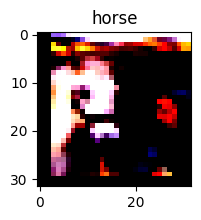

In [21]:
image = image.transpose(0, 2).transpose(0, 1)
label_map = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
print(f"Image shape: {image.shape}")
plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.title(label_map[label])

In [22]:
for batch, (X, y) in enumerate(train_dataloader):
    print(X.shape, y.shape)
    break

torch.Size([64, 3, 32, 32]) torch.Size([64])


# 功能函数

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_acc = 0.0

    def early_stop(self, validation_acc):
        if validation_acc > self.max_validation_acc:
            self.max_validation_acc = validation_acc
            self.counter = 0
        elif validation_acc < (self.max_validation_acc - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

def val_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    val_loss, val_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            val_pred = model(X)
            
            # 2. Calculate loss and accuracy
            val_loss += loss_fn(val_pred, y)
            val_acc += accuracy_fn(y_true=y,
                y_pred=val_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        val_loss /= len(data_loader)
        val_acc /= len(data_loader)
        print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")
        return val_loss, val_acc

def train(model, loss, optimizer, train_dataloader, val_dataloader, 
          scheduler=None, 
          num_epochs=10, 
          device=device, 
          early_stopper=EarlyStopper(patience=8, min_delta=0.02)):
    def convert(array):
        return [i.detach().cpu().numpy() for i in array]
    
    model.to(device)
    #fig, axs = plt.subplots(2, figsize=(4, 3*2))
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch {epoch + 1}\n-------------------------------")
        train_loss, train_acc = train_step(model, train_dataloader, loss, optimizer, accuracy_fn, device)
        val_loss, val_acc = val_step(val_dataloader, model, loss, accuracy_fn, device)
        scheduler.step()
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc / 100)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc / 100)
        if early_stopper.early_stop(val_acc):
            print("Early stopping at epoch", epoch+1)
            break

    print("Finished training")
    plt.plot(range(1,len(train_loss_list)+1), convert(train_loss_list), label="train_loss")
    plt.plot(range(1,len(val_loss_list)+1), convert(val_loss_list), label="val_loss")
    plt.plot(range(1,len(val_acc_list)+1), val_acc_list, linestyle='--',label="val_acc")
    plt.legend()
    #axs[1].plot(range(1,num_epochs+1), train_acc_list, linestyle='-',label="train_acc")
    #axs[1].legend()
    
def init_cnn(module):  
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.kaiming_uniform_(module.weight)

def layer_summary(model, X_shape):
    X = torch.randn(*X_shape)
    for layer in model.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)



# 模型训练


## 线性分类
### 定义

In [7]:
class FlatternModel(nn.Module):
    def __init__(self, input_size=3*32*32, output_size=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )
    
    def forward(self, x):
        return self.net(x)
    

### 训练

Epoch 1
-------------------------------
Train loss: 4.29119 | Train accuracy: 10.06%
Validation loss: 2.30840 | Validation accuracy: 9.95%

Epoch 2
-------------------------------
Train loss: 2.31562 | Train accuracy: 10.05%
Validation loss: 2.31393 | Validation accuracy: 10.29%

Epoch 3
-------------------------------
Train loss: 2.31553 | Train accuracy: 10.01%
Validation loss: 2.30567 | Validation accuracy: 10.29%

Epoch 4
-------------------------------
Train loss: 2.31568 | Train accuracy: 10.03%
Validation loss: 2.31452 | Validation accuracy: 9.95%

Epoch 5
-------------------------------
Train loss: 2.31471 | Train accuracy: 9.82%
Validation loss: 2.31339 | Validation accuracy: 9.68%

Epoch 6
-------------------------------
Train loss: 2.31708 | Train accuracy: 10.19%
Validation loss: 2.32653 | Validation accuracy: 9.51%

Epoch 7
-------------------------------
Train loss: 2.31593 | Train accuracy: 9.71%
Validation loss: 2.31766 | Validation accuracy: 10.14%

Epoch 8
-----------

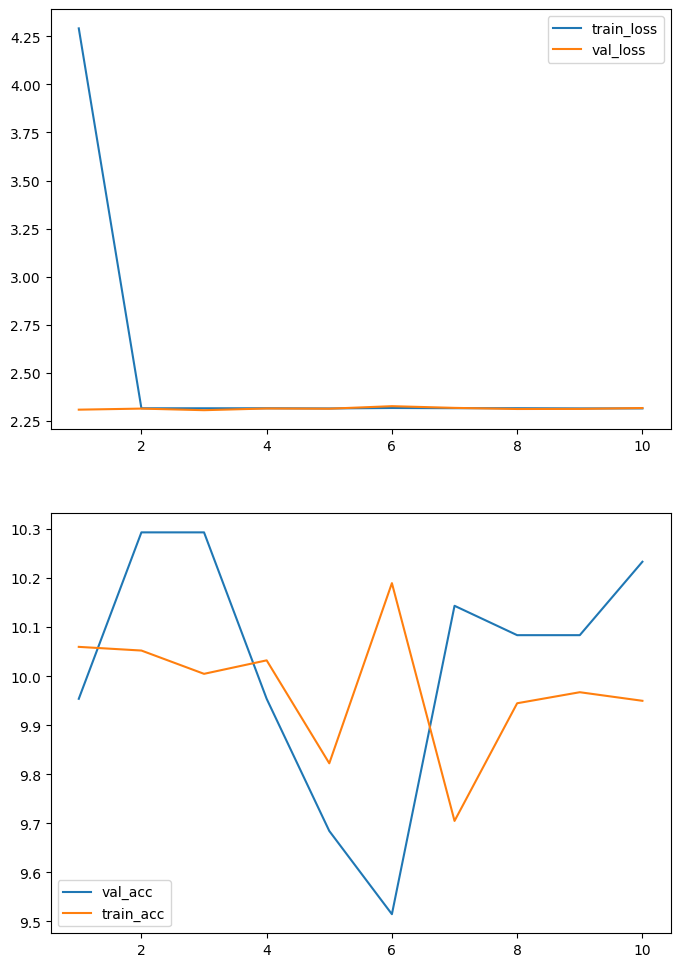

In [16]:
%%time
model = FlatternModel()
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

train(model, loss_fn, optimizer, train_dataloader, val_dataloader, num_epochs=10, device=device)

## LeNet
### 最早的尝试
#### 定义

In [14]:
class LeNet(nn.Module): 
    """The LeNet-5 model."""
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))
        init_cnn(self.net)
    
    def forward(self, X):
        return self.net(X)
    
model = LeNet()
layer_summary(model, (1, 3, 32, 32))

Conv2d output shape:	 torch.Size([1, 6, 32, 32])
ReLU output shape:	 torch.Size([1, 6, 32, 32])
AvgPool2d output shape:	 torch.Size([1, 6, 16, 16])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
ReLU output shape:	 torch.Size([1, 16, 12, 12])
AvgPool2d output shape:	 torch.Size([1, 16, 6, 6])
Flatten output shape:	 torch.Size([1, 576])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


e:\anaconda\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### 训练

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Train loss: 2.30056 | Train accuracy: 11.62%
Validation loss: 2.29262 | Validation accuracy: 15.73%

Epoch 2
-------------------------------
Train loss: 2.13812 | Train accuracy: 20.82%
Validation loss: 1.99636 | Validation accuracy: 26.41%

Epoch 3
-------------------------------
Train loss: 1.89703 | Train accuracy: 31.51%
Validation loss: 1.82957 | Validation accuracy: 33.42%

Epoch 4
-------------------------------
Train loss: 1.78164 | Train accuracy: 36.37%
Validation loss: 1.81556 | Validation accuracy: 33.70%

Epoch 5
-------------------------------
Train loss: 1.69633 | Train accuracy: 39.25%
Validation loss: 1.66429 | Validation accuracy: 40.01%

Epoch 6
-------------------------------
Train loss: 1.61452 | Train accuracy: 42.08%
Validation loss: 1.62729 | Validation accuracy: 41.20%

Epoch 7
-------------------------------
Train loss: 1.54663 | Train accuracy: 44.56%
Validation loss: 1.54293 | Validation accuracy: 44.62%

Epoch 8
-----

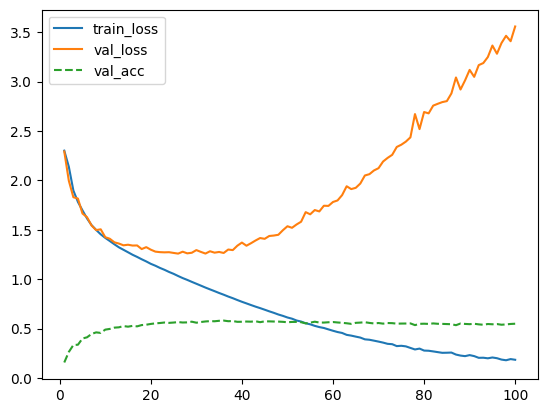

In [15]:
%%time
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

train(model, loss, optimizer, train_dataloader, val_dataloader, num_epochs=100, device=device)

### 添加了BatchNorm和数据增强

In [41]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

class LeNet_with_norm(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.net = nn.Sequential(
            conv_block(6),
            nn.AvgPool2d(kernel_size=2, stride=2),
            conv_block(6),
            nn.AvgPool2d(kernel_size=2, stride=2),
            conv_block(6),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))
        init_cnn(self.net)
    
    def forward(self, X):
        return self.net(X)
    
model = LeNet_with_norm()
X = torch.randn(1, 3, 32, 32)
layer_summary(model, X.shape)

Sequential output shape:	 torch.Size([1, 6, 32, 32])
AvgPool2d output shape:	 torch.Size([1, 6, 16, 16])
Sequential output shape:	 torch.Size([1, 6, 16, 16])
AvgPool2d output shape:	 torch.Size([1, 6, 8, 8])
Sequential output shape:	 torch.Size([1, 6, 8, 8])
AvgPool2d output shape:	 torch.Size([1, 6, 4, 4])
Flatten output shape:	 torch.Size([1, 96])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Train loss: 2.23751 | Train accuracy: 16.68%
Validation loss: 2.17876 | Validation accuracy: 20.07%

Epoch 2
-------------------------------
Train loss: 2.12535 | Train accuracy: 22.09%
Validation loss: 2.09853 | Validation accuracy: 23.58%

Epoch 3
-------------------------------
Train loss: 2.03220 | Train accuracy: 26.60%
Validation loss: 2.04043 | Validation accuracy: 26.73%

Epoch 4
-------------------------------
Train loss: 1.95747 | Train accuracy: 29.39%
Validation loss: 1.94420 | Validation accuracy: 30.40%

Epoch 5
-------------------------------
Train loss: 1.90240 | Train accuracy: 31.70%
Validation loss: 1.87428 | Validation accuracy: 33.41%

Epoch 6
-------------------------------
Train loss: 1.87106 | Train accuracy: 33.16%
Validation loss: 1.86206 | Validation accuracy: 33.56%

Epoch 7
-------------------------------
Train loss: 1.84572 | Train accuracy: 33.93%
Validation loss: 1.81660 | Validation accuracy: 34.38%

Epoch 8
-----

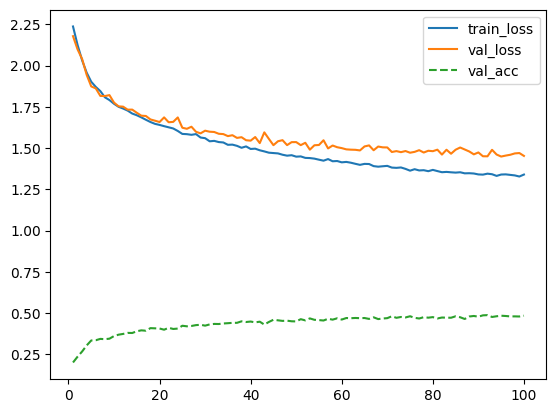

In [42]:
%%time
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train(model, loss, optimizer, train_dataloader, val_dataloader, num_epochs=100, device=device)

### 保存

In [16]:
MODEL_NAME = "lenet_cifar10.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj=model.state_dict(), 
           f=MODEL_SAVE_PATH)

## ResNet
### 定义
模仿了ResNet18的结构，但是ResNet18是在ImageNet上训练的，CIFAR-10的分辨率低很多，所以第一个 $7*7$ 卷积换成了 $5*5$ 的。

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = nn.Dropout2d(0.1)(Y)
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

class BottleNeckResidualBlock(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=1,
                                   stride=1)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv4 = nn.LazyConv2d(num_channels*4, kernel_size=1, stride=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = nn.Dropout2d(0.1)(Y)
        Y = self.bn2(self.conv2(Y))
        Y = nn.Dropout2d(0.1)(Y)
        Y = self.conv4(Y)
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
 
class ResNet(nn.Module):
    def __init__(self, arch, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.net.add_module(f"b{i+2}", self.block(*b, first_block=(i==0)))
        
        self.net.add_module("last", nn.Sequential(      
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.LazyLinear(num_classes)
        ))
        init_cnn(self.net)

    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        if num_residuals <= 2:
            for i in range(num_residuals):
                if i == 0 and not first_block:
                    blk.append(ResidualBlock(num_channels, use_1x1conv=True, strides=2))
                else:
                    blk.append(ResidualBlock(num_channels))
            return nn.Sequential(*blk)
        elif num_residuals >= 2:
            for i in range(num_residuals):
                if i == 0 and not first_block:
                    blk.append(BottleNeckResidualBlock(num_channels, use_1x1conv=True, strides=2))
                else:
                    blk.append(BottleNeckResidualBlock(num_channels))
            return nn.Sequential(*blk)           

    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=3, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def forward(self, X):
        return self.net(X)
    
model = ResNet(arch=[[2, 64], [2, 128], [2, 256], [2, 512]], num_classes=10)
layer_summary(model, (1, 3, 32, 32))

Sequential output shape:	 torch.Size([1, 64, 9, 9])
Sequential output shape:	 torch.Size([1, 64, 9, 9])
Sequential output shape:	 torch.Size([1, 128, 5, 5])
Sequential output shape:	 torch.Size([1, 256, 3, 3])
Sequential output shape:	 torch.Size([1, 512, 2, 2])
Sequential output shape:	 torch.Size([1, 10])


### 训练

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Train loss: 1.88174 | Train accuracy: 28.38%
Validation loss: 1.64931 | Validation accuracy: 39.13%

Epoch 2
-------------------------------
Train loss: 1.60362 | Train accuracy: 40.09%
Validation loss: 1.48545 | Validation accuracy: 44.71%

Epoch 3
-------------------------------
Train loss: 1.43266 | Train accuracy: 47.74%
Validation loss: 1.39819 | Validation accuracy: 48.85%

Epoch 4
-------------------------------
Train loss: 1.30400 | Train accuracy: 52.68%
Validation loss: 1.29405 | Validation accuracy: 53.31%

Epoch 5
-------------------------------
Train loss: 1.22185 | Train accuracy: 56.12%
Validation loss: 1.20200 | Validation accuracy: 57.75%

Epoch 6
-------------------------------
Train loss: 1.13787 | Train accuracy: 59.42%
Validation loss: 1.23389 | Validation accuracy: 57.24%

Epoch 7
-------------------------------
Train loss: 1.08515 | Train accuracy: 61.45%
Validation loss: 1.15780 | Validation accuracy: 59.70%

Epoch 8
-----

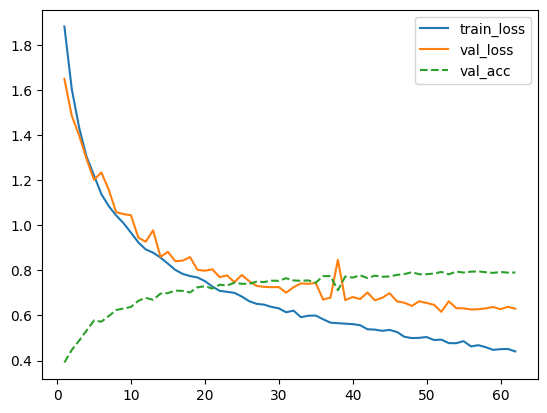

In [22]:
%%time
model = ResNet(arch=[[2, 64], [2, 128], [2, 256], [2, 512]], num_classes=10)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9, last_epoch=-1)
train(model, loss, optimizer, train_dataloader, val_dataloader, scheduler=scheduler, num_epochs=100, device=device)

### 更大的Dropout

In [34]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = nn.Dropout2d(0.5)(Y)
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

class ResNet(nn.Module):
    def __init__(self, arch, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.net.add_module(f"b{i+2}", self.block(*b, first_block=(i==0)))
        
        self.net.add_module("last", nn.Sequential(      
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.LazyLinear(num_classes)
        ))

        init_cnn(self.net)

    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(ResidualBlock(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(ResidualBlock(num_channels))
        return nn.Sequential(*blk)

    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=5, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    def forward(self, X):
        return self.net(X)
    
model = ResNet(arch=[[2, 64], [2, 128], [2, 256], [2, 512]], num_classes=10)
#layer_summary(model, (1, 3, 32, 32))

e:\anaconda\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### 加入L2正则化

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1
-------------------------------


Train loss: 2.24970 | Train accuracy: 17.57%


  1%|          | 1/100 [00:22<37:03, 22.46s/it]

Validation loss: 2.03435 | Validation accuracy: 24.52%

Epoch 2
-------------------------------
Train loss: 1.80630 | Train accuracy: 30.91%


  2%|▏         | 2/100 [00:37<29:23, 17.99s/it]

Validation loss: 1.65374 | Validation accuracy: 37.05%

Epoch 3
-------------------------------
Train loss: 1.62110 | Train accuracy: 38.88%


  3%|▎         | 3/100 [00:51<26:36, 16.45s/it]

Validation loss: 1.54102 | Validation accuracy: 42.11%

Epoch 4
-------------------------------
Train loss: 1.52664 | Train accuracy: 43.10%


  4%|▍         | 4/100 [01:06<25:17, 15.81s/it]

Validation loss: 1.53112 | Validation accuracy: 42.78%

Epoch 5
-------------------------------
Train loss: 1.45401 | Train accuracy: 46.15%


  5%|▌         | 5/100 [01:21<24:13, 15.30s/it]

Validation loss: 1.55960 | Validation accuracy: 42.89%

Epoch 6
-------------------------------
Train loss: 1.41242 | Train accuracy: 48.04%


  6%|▌         | 6/100 [01:35<23:34, 15.05s/it]

Validation loss: 1.40815 | Validation accuracy: 48.34%

Epoch 7
-------------------------------
Train loss: 1.36947 | Train accuracy: 49.79%


  7%|▋         | 7/100 [01:50<23:09, 14.94s/it]

Validation loss: 1.36069 | Validation accuracy: 50.08%

Epoch 8
-------------------------------
Train loss: 1.31992 | Train accuracy: 51.75%


  8%|▊         | 8/100 [02:04<22:42, 14.81s/it]

Validation loss: 1.33160 | Validation accuracy: 51.92%

Epoch 9
-------------------------------
Train loss: 1.27595 | Train accuracy: 53.47%


  9%|▉         | 9/100 [02:19<22:17, 14.69s/it]

Validation loss: 1.30368 | Validation accuracy: 53.92%

Epoch 10
-------------------------------
Train loss: 1.24340 | Train accuracy: 55.13%


 10%|█         | 10/100 [02:34<22:10, 14.78s/it]

Validation loss: 1.21485 | Validation accuracy: 56.62%

Epoch 11
-------------------------------
Train loss: 1.20671 | Train accuracy: 56.49%


 11%|█         | 11/100 [02:48<21:49, 14.72s/it]

Validation loss: 1.14823 | Validation accuracy: 58.68%

Epoch 12
-------------------------------
Train loss: 1.18207 | Train accuracy: 57.37%


 12%|█▏        | 12/100 [03:03<21:40, 14.78s/it]

Validation loss: 1.18101 | Validation accuracy: 57.66%

Epoch 13
-------------------------------
Train loss: 1.15745 | Train accuracy: 58.53%


 13%|█▎        | 13/100 [03:18<21:25, 14.78s/it]

Validation loss: 1.15739 | Validation accuracy: 58.00%

Epoch 14
-------------------------------
Train loss: 1.14581 | Train accuracy: 59.20%


 14%|█▍        | 14/100 [03:33<21:20, 14.89s/it]

Validation loss: 1.15429 | Validation accuracy: 58.97%

Epoch 15
-------------------------------
Train loss: 1.13045 | Train accuracy: 59.73%


 15%|█▌        | 15/100 [03:48<20:53, 14.74s/it]

Validation loss: 1.15205 | Validation accuracy: 58.85%

Epoch 16
-------------------------------
Train loss: 1.11574 | Train accuracy: 60.22%


 16%|█▌        | 16/100 [04:02<20:35, 14.71s/it]

Validation loss: 1.12056 | Validation accuracy: 59.43%

Epoch 17
-------------------------------
Train loss: 1.11008 | Train accuracy: 60.51%


 17%|█▋        | 17/100 [04:17<20:18, 14.68s/it]

Validation loss: 1.09644 | Validation accuracy: 60.52%

Epoch 18
-------------------------------
Train loss: 1.10164 | Train accuracy: 60.58%


 18%|█▊        | 18/100 [04:32<20:05, 14.70s/it]

Validation loss: 1.10497 | Validation accuracy: 60.73%

Epoch 19
-------------------------------
Train loss: 1.09244 | Train accuracy: 61.09%


 19%|█▉        | 19/100 [04:46<19:47, 14.67s/it]

Validation loss: 1.18714 | Validation accuracy: 58.02%

Epoch 20
-------------------------------
Train loss: 1.07964 | Train accuracy: 61.78%


 20%|██        | 20/100 [05:01<19:35, 14.69s/it]

Validation loss: 1.08077 | Validation accuracy: 62.25%

Epoch 21
-------------------------------
Train loss: 1.05623 | Train accuracy: 62.64%


 21%|██        | 21/100 [05:15<19:12, 14.59s/it]

Validation loss: 1.04138 | Validation accuracy: 62.80%

Epoch 22
-------------------------------
Train loss: 1.05507 | Train accuracy: 62.62%


 22%|██▏       | 22/100 [05:30<18:58, 14.60s/it]

Validation loss: 1.06971 | Validation accuracy: 61.99%

Epoch 23
-------------------------------
Train loss: 1.04457 | Train accuracy: 62.94%


 23%|██▎       | 23/100 [05:45<18:47, 14.64s/it]

Validation loss: 1.04914 | Validation accuracy: 62.94%

Epoch 24
-------------------------------
Train loss: 1.03841 | Train accuracy: 63.42%


 24%|██▍       | 24/100 [05:59<18:33, 14.65s/it]

Validation loss: 1.05470 | Validation accuracy: 62.99%

Epoch 25
-------------------------------
Train loss: 1.03032 | Train accuracy: 63.02%


 25%|██▌       | 25/100 [06:14<18:12, 14.56s/it]

Validation loss: 1.01713 | Validation accuracy: 63.65%

Epoch 26
-------------------------------
Train loss: 1.03109 | Train accuracy: 63.79%


 26%|██▌       | 26/100 [06:28<17:50, 14.47s/it]

Validation loss: 1.02418 | Validation accuracy: 64.32%

Epoch 27
-------------------------------
Train loss: 1.01791 | Train accuracy: 64.18%


 27%|██▋       | 27/100 [06:42<17:31, 14.40s/it]

Validation loss: 1.06299 | Validation accuracy: 62.73%

Epoch 28
-------------------------------
Train loss: 1.01770 | Train accuracy: 64.11%


 28%|██▊       | 28/100 [06:56<17:13, 14.35s/it]

Validation loss: 1.06524 | Validation accuracy: 61.81%

Epoch 29
-------------------------------
Train loss: 1.01129 | Train accuracy: 64.44%


 29%|██▉       | 29/100 [07:11<16:58, 14.34s/it]

Validation loss: 1.06842 | Validation accuracy: 62.69%

Epoch 30
-------------------------------
Train loss: 1.00489 | Train accuracy: 64.48%


 30%|███       | 30/100 [07:25<16:44, 14.36s/it]

Validation loss: 1.04909 | Validation accuracy: 62.59%

Epoch 31
-------------------------------
Train loss: 0.98742 | Train accuracy: 64.94%


 31%|███       | 31/100 [07:39<16:28, 14.32s/it]

Validation loss: 1.00667 | Validation accuracy: 64.21%

Epoch 32
-------------------------------
Train loss: 0.99204 | Train accuracy: 64.90%


 32%|███▏      | 32/100 [07:54<16:13, 14.31s/it]

Validation loss: 1.05240 | Validation accuracy: 62.39%

Epoch 33
-------------------------------
Train loss: 0.98511 | Train accuracy: 65.29%


 33%|███▎      | 33/100 [08:08<16:00, 14.33s/it]

Validation loss: 1.00850 | Validation accuracy: 64.49%

Epoch 34
-------------------------------
Train loss: 0.98715 | Train accuracy: 65.18%


 34%|███▍      | 34/100 [08:22<15:41, 14.27s/it]

Validation loss: 0.96827 | Validation accuracy: 65.36%

Epoch 35
-------------------------------
Train loss: 0.98231 | Train accuracy: 65.43%


 35%|███▌      | 35/100 [08:37<15:30, 14.31s/it]

Validation loss: 1.02513 | Validation accuracy: 64.37%

Epoch 36
-------------------------------
Train loss: 0.97498 | Train accuracy: 65.88%


 36%|███▌      | 36/100 [08:51<15:13, 14.27s/it]

Validation loss: 0.99380 | Validation accuracy: 64.86%

Epoch 37
-------------------------------
Train loss: 0.97498 | Train accuracy: 65.51%


 37%|███▋      | 37/100 [09:05<15:00, 14.30s/it]

Validation loss: 0.99884 | Validation accuracy: 65.02%

Epoch 38
-------------------------------
Train loss: 0.97492 | Train accuracy: 65.73%


 38%|███▊      | 38/100 [09:19<14:45, 14.28s/it]

Validation loss: 1.00616 | Validation accuracy: 64.03%

Epoch 39
-------------------------------
Train loss: 0.96965 | Train accuracy: 65.90%


 39%|███▉      | 39/100 [09:34<14:29, 14.26s/it]

Validation loss: 0.99765 | Validation accuracy: 64.90%

Epoch 40
-------------------------------
Train loss: 0.97057 | Train accuracy: 65.90%


 40%|████      | 40/100 [09:48<14:10, 14.17s/it]

Validation loss: 0.98725 | Validation accuracy: 65.22%

Epoch 41
-------------------------------
Train loss: 0.95295 | Train accuracy: 66.69%


 41%|████      | 41/100 [10:02<13:56, 14.19s/it]

Validation loss: 0.94263 | Validation accuracy: 66.98%

Epoch 42
-------------------------------
Train loss: 0.94003 | Train accuracy: 66.99%


 42%|████▏     | 42/100 [10:16<13:43, 14.20s/it]

Validation loss: 0.95494 | Validation accuracy: 66.04%

Epoch 43
-------------------------------
Train loss: 0.95200 | Train accuracy: 66.89%


 43%|████▎     | 43/100 [10:30<13:28, 14.18s/it]

Validation loss: 0.97043 | Validation accuracy: 65.66%

Epoch 44
-------------------------------
Train loss: 0.94457 | Train accuracy: 66.89%


 44%|████▍     | 44/100 [10:44<13:16, 14.22s/it]

Validation loss: 0.94770 | Validation accuracy: 66.07%

Epoch 45
-------------------------------
Train loss: 0.94774 | Train accuracy: 66.88%


 45%|████▌     | 45/100 [10:59<12:59, 14.16s/it]

Validation loss: 0.95697 | Validation accuracy: 66.52%

Epoch 46
-------------------------------
Train loss: 0.93708 | Train accuracy: 66.93%


 46%|████▌     | 46/100 [11:13<12:44, 14.15s/it]

Validation loss: 0.95445 | Validation accuracy: 66.49%

Epoch 47
-------------------------------
Train loss: 0.93318 | Train accuracy: 67.38%


 47%|████▋     | 47/100 [11:27<12:32, 14.20s/it]

Validation loss: 0.93389 | Validation accuracy: 66.94%

Epoch 48
-------------------------------
Train loss: 0.92521 | Train accuracy: 67.49%


 48%|████▊     | 48/100 [11:41<12:18, 14.21s/it]

Validation loss: 0.98636 | Validation accuracy: 65.22%

Epoch 49
-------------------------------
Train loss: 0.93551 | Train accuracy: 67.13%


 49%|████▉     | 49/100 [11:56<12:06, 14.24s/it]

Validation loss: 0.93797 | Validation accuracy: 67.30%

Epoch 50
-------------------------------
Train loss: 0.93656 | Train accuracy: 67.25%


 50%|█████     | 50/100 [12:10<11:51, 14.24s/it]

Validation loss: 0.93558 | Validation accuracy: 67.12%

Epoch 51
-------------------------------
Train loss: 0.92050 | Train accuracy: 67.71%


 51%|█████     | 51/100 [12:23<11:30, 14.09s/it]

Validation loss: 0.92317 | Validation accuracy: 67.94%

Epoch 52
-------------------------------
Train loss: 0.91413 | Train accuracy: 67.80%


 52%|█████▏    | 52/100 [12:38<11:18, 14.14s/it]

Validation loss: 0.92355 | Validation accuracy: 67.84%

Epoch 53
-------------------------------
Train loss: 0.90324 | Train accuracy: 68.19%


 53%|█████▎    | 53/100 [12:52<11:03, 14.11s/it]

Validation loss: 0.96239 | Validation accuracy: 66.31%

Epoch 54
-------------------------------
Train loss: 0.91475 | Train accuracy: 67.88%


 54%|█████▍    | 54/100 [13:06<10:49, 14.12s/it]

Validation loss: 0.96471 | Validation accuracy: 65.81%

Epoch 55
-------------------------------
Train loss: 0.90767 | Train accuracy: 68.25%


 55%|█████▌    | 55/100 [13:20<10:37, 14.17s/it]

Validation loss: 0.94331 | Validation accuracy: 66.51%

Epoch 56
-------------------------------
Train loss: 0.91195 | Train accuracy: 68.04%


 56%|█████▌    | 56/100 [13:35<10:28, 14.28s/it]

Validation loss: 0.95658 | Validation accuracy: 66.94%

Epoch 57
-------------------------------
Train loss: 0.90139 | Train accuracy: 68.57%


 57%|█████▋    | 57/100 [13:49<10:14, 14.28s/it]

Validation loss: 0.92026 | Validation accuracy: 67.32%

Epoch 58
-------------------------------
Train loss: 0.89437 | Train accuracy: 68.77%


 58%|█████▊    | 58/100 [14:03<10:00, 14.29s/it]

Validation loss: 0.95667 | Validation accuracy: 66.44%

Epoch 59
-------------------------------
Train loss: 0.90433 | Train accuracy: 68.48%


 59%|█████▉    | 59/100 [14:18<09:45, 14.29s/it]

Validation loss: 0.93113 | Validation accuracy: 67.24%

Epoch 60
-------------------------------
Train loss: 0.89981 | Train accuracy: 68.51%


 60%|██████    | 60/100 [14:32<09:29, 14.23s/it]

Validation loss: 0.96231 | Validation accuracy: 67.13%

Epoch 61
-------------------------------
Train loss: 0.88628 | Train accuracy: 68.86%


 61%|██████    | 61/100 [14:46<09:14, 14.21s/it]

Validation loss: 0.89723 | Validation accuracy: 68.65%

Epoch 62
-------------------------------
Train loss: 0.88594 | Train accuracy: 69.01%


 62%|██████▏   | 62/100 [15:00<09:01, 14.25s/it]

Validation loss: 0.94134 | Validation accuracy: 66.70%

Epoch 63
-------------------------------
Train loss: 0.88609 | Train accuracy: 68.86%


 63%|██████▎   | 63/100 [15:15<08:48, 14.29s/it]

Validation loss: 0.90039 | Validation accuracy: 68.37%

Epoch 64
-------------------------------
Train loss: 0.88446 | Train accuracy: 69.07%


 64%|██████▍   | 64/100 [15:29<08:35, 14.33s/it]

Validation loss: 0.96072 | Validation accuracy: 66.61%

Epoch 65
-------------------------------
Train loss: 0.87966 | Train accuracy: 69.54%


 65%|██████▌   | 65/100 [15:43<08:23, 14.37s/it]

Validation loss: 0.90440 | Validation accuracy: 68.78%

Epoch 66
-------------------------------
Train loss: 0.87914 | Train accuracy: 69.27%


 66%|██████▌   | 66/100 [15:59<08:17, 14.64s/it]

Validation loss: 0.94994 | Validation accuracy: 67.19%

Epoch 67
-------------------------------
Train loss: 0.87752 | Train accuracy: 69.41%


 67%|██████▋   | 67/100 [16:14<08:06, 14.75s/it]

Validation loss: 0.87836 | Validation accuracy: 69.05%

Epoch 68
-------------------------------
Train loss: 0.87041 | Train accuracy: 69.45%


 68%|██████▊   | 68/100 [16:28<07:49, 14.67s/it]

Validation loss: 0.91638 | Validation accuracy: 68.22%

Epoch 69
-------------------------------
Train loss: 0.87579 | Train accuracy: 69.36%


 69%|██████▉   | 69/100 [16:43<07:31, 14.57s/it]

Validation loss: 0.88538 | Validation accuracy: 68.63%

Epoch 70
-------------------------------
Train loss: 0.87374 | Train accuracy: 69.45%


 70%|███████   | 70/100 [16:57<07:16, 14.57s/it]

Validation loss: 0.87845 | Validation accuracy: 69.36%

Epoch 71
-------------------------------
Train loss: 0.86664 | Train accuracy: 69.66%


 71%|███████   | 71/100 [17:12<07:04, 14.64s/it]

Validation loss: 0.88563 | Validation accuracy: 68.60%

Epoch 72
-------------------------------
Train loss: 0.86907 | Train accuracy: 69.73%


 72%|███████▏  | 72/100 [17:27<06:49, 14.64s/it]

Validation loss: 0.86547 | Validation accuracy: 69.86%

Epoch 73
-------------------------------
Train loss: 0.84995 | Train accuracy: 70.18%


 73%|███████▎  | 73/100 [17:41<06:33, 14.58s/it]

Validation loss: 0.88236 | Validation accuracy: 69.49%

Epoch 74
-------------------------------
Train loss: 0.86253 | Train accuracy: 69.95%


 74%|███████▍  | 74/100 [17:55<06:18, 14.54s/it]

Validation loss: 0.88096 | Validation accuracy: 68.78%

Epoch 75
-------------------------------
Train loss: 0.85368 | Train accuracy: 70.26%


 75%|███████▌  | 75/100 [18:10<06:05, 14.62s/it]

Validation loss: 0.88350 | Validation accuracy: 68.79%

Epoch 76
-------------------------------
Train loss: 0.85192 | Train accuracy: 70.10%


 76%|███████▌  | 76/100 [18:25<05:48, 14.54s/it]

Validation loss: 0.93102 | Validation accuracy: 68.13%

Epoch 77
-------------------------------
Train loss: 0.85369 | Train accuracy: 70.17%


 77%|███████▋  | 77/100 [18:39<05:33, 14.51s/it]

Validation loss: 0.92478 | Validation accuracy: 67.62%

Epoch 78
-------------------------------
Train loss: 0.85045 | Train accuracy: 70.08%


 78%|███████▊  | 78/100 [18:54<05:19, 14.54s/it]

Validation loss: 0.88240 | Validation accuracy: 69.17%

Epoch 79
-------------------------------
Train loss: 0.85397 | Train accuracy: 69.88%


 79%|███████▉  | 79/100 [19:09<05:07, 14.64s/it]

Validation loss: 0.86715 | Validation accuracy: 69.64%

Epoch 80
-------------------------------
Train loss: 0.85057 | Train accuracy: 70.45%


 80%|████████  | 80/100 [19:23<04:50, 14.53s/it]

Validation loss: 0.88424 | Validation accuracy: 69.76%

Epoch 81
-------------------------------
Train loss: 0.83853 | Train accuracy: 70.60%


 81%|████████  | 81/100 [19:37<04:36, 14.57s/it]

Validation loss: 0.88895 | Validation accuracy: 69.59%

Epoch 82
-------------------------------
Train loss: 0.84253 | Train accuracy: 70.26%


 82%|████████▏ | 82/100 [19:52<04:22, 14.57s/it]

Validation loss: 0.85676 | Validation accuracy: 70.25%

Epoch 83
-------------------------------
Train loss: 0.83817 | Train accuracy: 70.87%


 83%|████████▎ | 83/100 [20:06<04:06, 14.52s/it]

Validation loss: 0.87403 | Validation accuracy: 70.16%

Epoch 84
-------------------------------
Train loss: 0.82953 | Train accuracy: 71.19%


 84%|████████▍ | 84/100 [20:21<03:51, 14.46s/it]

Validation loss: 0.87314 | Validation accuracy: 69.35%

Epoch 85
-------------------------------
Train loss: 0.83218 | Train accuracy: 71.13%


 85%|████████▌ | 85/100 [20:35<03:36, 14.46s/it]

Validation loss: 0.87251 | Validation accuracy: 69.85%

Epoch 86
-------------------------------
Train loss: 0.83031 | Train accuracy: 71.06%


 86%|████████▌ | 86/100 [20:50<03:23, 14.56s/it]

Validation loss: 0.86072 | Validation accuracy: 69.51%

Epoch 87
-------------------------------
Train loss: 0.83118 | Train accuracy: 71.05%


 87%|████████▋ | 87/100 [21:05<03:10, 14.63s/it]

Validation loss: 0.87139 | Validation accuracy: 69.89%

Epoch 88
-------------------------------
Train loss: 0.83125 | Train accuracy: 71.23%


 88%|████████▊ | 88/100 [21:19<02:54, 14.52s/it]

Validation loss: 0.86238 | Validation accuracy: 69.72%

Epoch 89
-------------------------------
Train loss: 0.82750 | Train accuracy: 71.00%


 89%|████████▉ | 89/100 [21:34<02:40, 14.59s/it]

Validation loss: 0.88648 | Validation accuracy: 69.03%

Epoch 90
-------------------------------
Train loss: 0.83369 | Train accuracy: 70.96%


 90%|█████████ | 90/100 [21:49<02:26, 14.63s/it]

Validation loss: 0.88072 | Validation accuracy: 69.03%

Epoch 91
-------------------------------
Train loss: 0.81504 | Train accuracy: 71.56%


 91%|█████████ | 91/100 [22:03<02:11, 14.64s/it]

Validation loss: 0.92182 | Validation accuracy: 68.00%

Epoch 92
-------------------------------
Train loss: 0.82210 | Train accuracy: 71.43%


 91%|█████████ | 91/100 [22:18<02:12, 14.70s/it]

Validation loss: 0.86135 | Validation accuracy: 69.85%

Early stopping at epoch 92
Finished training


CPU times: user 22min 16s, sys: 1min 11s, total: 23min 28s
Wall time: 22min 22s


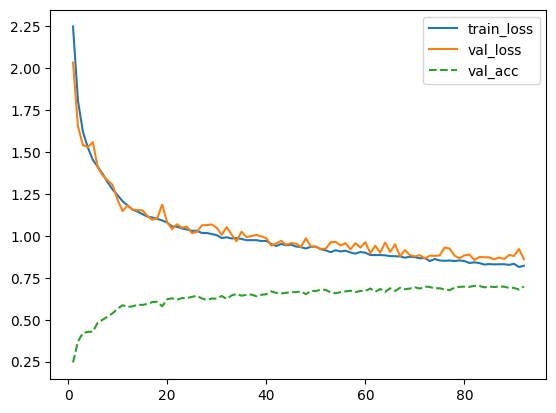

In [35]:
%%time
model = ResNet(arch=[[3, 64], [4, 128], [6, 256], [3, 512]], num_classes=10)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9, last_epoch=-1)
train(model, loss, optimizer, train_dataloader, val_dataloader, scheduler=scheduler, 
      num_epochs=100, device=device, early_stopper=EarlyStopper(patience=10, min_delta=0.01))

### 保存

In [35]:
MODEL_NAME = "ResNet_cifar10.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj=model.state_dict(), 
           f=MODEL_SAVE_PATH)

## DenseNet
### 定义

In [4]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels // 8, kernel_size=1),
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

class DenseNet(nn.Module):
    def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
                 num_classes=10):
        super(DenseNet, self).__init__()
        self.net = nn.Sequential(self.b1())
        for i, num_convs in enumerate(arch):
            self.net.add_module(f'dense_block{i+1}', DenseBlock(num_convs,
                                                              growth_rate))
            # The number of output channels in the previous dense block
            num_channels += num_convs * growth_rate
            # A transition layer that halves the number of channels is added
            # between the dense blocks
            if i != len(arch) - 1:
                num_channels //= 2
                self.net.add_module(f'tran_blk{i+1}', transition_block(
                    num_channels))
        self.net.add_module('last', nn.Sequential(
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))
        init_cnn(self.net)

    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7 * 7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    
    def forward(self, X):
        return self.net(X)

model = DenseNet(arch=(6, 12, 32, 32))
X = torch.randn(1, 3, 224, 224)
layer_summary(model, X.shape)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 64, 46, 46])
DenseBlock output shape:	 torch.Size([1, 256, 46, 46])
Sequential output shape:	 torch.Size([1, 128, 23, 23])
DenseBlock output shape:	 torch.Size([1, 512, 23, 23])
Sequential output shape:	 torch.Size([1, 256, 11, 11])
DenseBlock output shape:	 torch.Size([1, 1280, 11, 11])
Sequential output shape:	 torch.Size([1, 640, 5, 5])
DenseBlock output shape:	 torch.Size([1, 1664, 5, 5])
Sequential output shape:	 torch.Size([1, 10])


### 训练

In [5]:
%%time
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9, last_epoch=-1)
train(model, loss, optimizer, train_dataloader, val_dataloader, scheduler=scheduler, num_epochs=200, 
      device=device, early_stopper=EarlyStopper(patience=10, min_delta=0.02))

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1
-------------------------------


  0%|          | 0/200 [00:11<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 66.00 MiB. GPU 0 has a total capacity of 7.75 GiB of which 8.75 MiB is free. Process 2941174 has 7.72 GiB memory in use. Of the allocated memory 7.47 GiB is allocated by PyTorch, and 134.72 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

e:\anaconda\envs\d2l\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anaconda\envs\d2l\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Train loss: 1.94129 | Train accuracy: 30.51%
Validation loss: 1.60267 | Validation accuracy: 40.51%

Epoch 2
-------------------------------
Train loss: 1.60692 | Train accuracy: 39.95%
Validation loss: 1.54355 | Validation accuracy: 43.33%

Epoch 3
-------------------------------
Train loss: 1.42265 | Train accuracy: 47.60%
Validation loss: 1.32748 | Validation accuracy: 52.20%

Epoch 4
-------------------------------
Train loss: 1.31530 | Train accuracy: 52.10%
Validation loss: 1.26671 | Validation accuracy: 54.47%

Epoch 5
-------------------------------
Train loss: 1.23048 | Train accuracy: 55.64%
Validation loss: 1.22543 | Validation accuracy: 56.33%

Epoch 6
-------------------------------
Train loss: 1.14537 | Train accuracy: 58.83%
Validation loss: 1.15599 | Validation accuracy: 58.59%

Epoch 7
-------------------------------
Train loss: 1.08919 | Train accuracy: 61.05%
Validation loss: 1.12573 | Validation accuracy: 60.04%

Epoch 8
-----

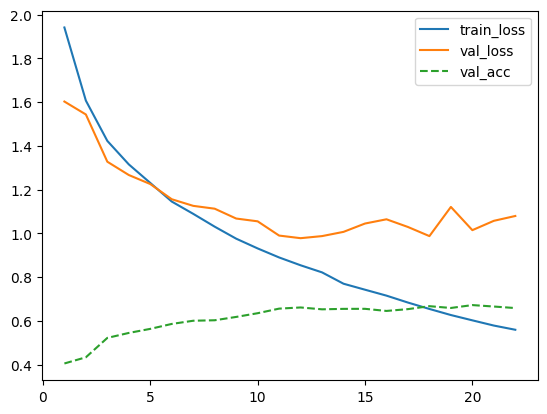

In [5]:
%%time
model = torchvision.models.densenet121(pretrained=False)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train(model, loss, optimizer, train_dataloader, val_dataloader, num_epochs=50, device=device, early_stopper=EarlyStopper(patience=8, min_delta=0.02))

### 保存

In [12]:
MODEL_NAME = "DenseNet_cifar10.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj=model.state_dict(), 
           f=MODEL_SAVE_PATH)

# 评估

In [6]:
load_model = ResNet(arch=[[2, 64], [2, 128], [2, 256], [2, 512]], num_classes=10)
MODEL_NAME = "ResNet_cifar10.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
load_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loss = nn.CrossEntropyLoss()
val_step(test_dataloader, load_model, loss, accuracy_fn, device=device)

Validation loss: 0.60185 | Validation accuracy: 79.94%



(tensor(0.6019, device='cuda:0'), 79.94209265175719)